In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv("benchmark/full_results.csv", header=None)

In [3]:
data.columns = ["dataloader", "iteration", "batch_size", "num_workers", "clock_time", "process_time"]

<AxesSubplot: xlabel='num_workers', ylabel='clock_time'>

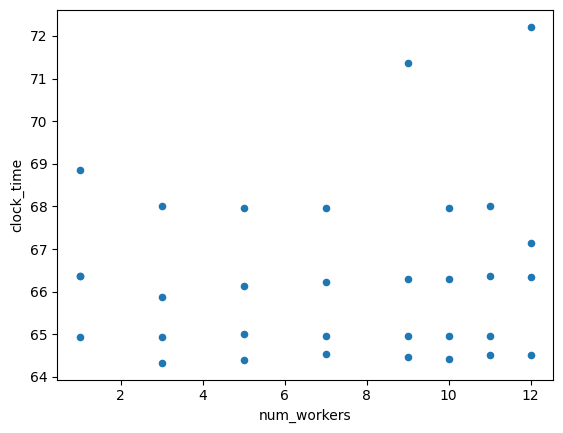

In [4]:
data[data.dataloader == "dali"].plot(x="num_workers", y="clock_time", kind="scatter")

<AxesSubplot: xlabel='num_workers', ylabel='clock_time'>

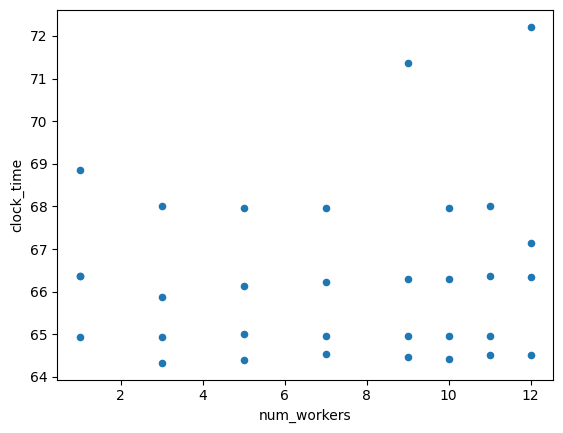

In [5]:
data[data.dataloader == "dali"].plot(x="num_workers", y="clock_time", kind="scatter")

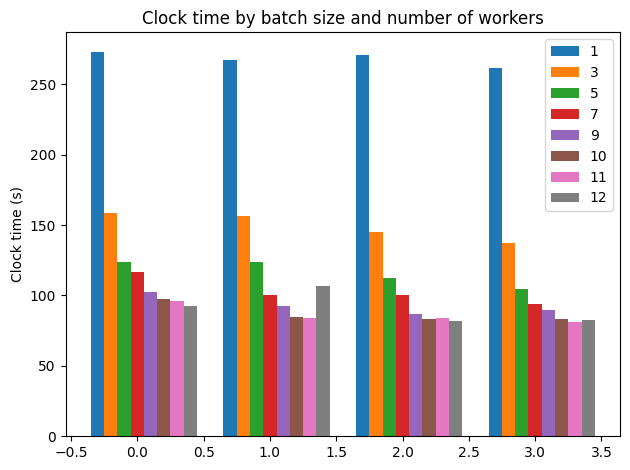

In [6]:
width = 0.1
num_workers = data.num_workers.unique()
num_workers.sort()
dali_data = data[data.dataloader == "dali"]

x = np.arange(data.batch_size.nunique())

fig, ax = plt.subplots()

rects = []

for i, nw in enumerate(num_workers):
    adj_x = x + width * (i + 1) - width * len(num_workers) / 2
    clock_by_batch = data[data.num_workers == nw].groupby("batch_size").agg(
        {"clock_time": "mean"}
    ).sort_index()
    y = clock_by_batch.clock_time.array
    
    rects.append(ax.bar(adj_x, y, width, label=nw))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Clock time (s)')
ax.set_title('Clock time by batch size and number of workers')
# ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.show()

In [21]:
def plot_times(data, dataloader, x1, x2, time_col, per_clip=True):
    width = 0.1
    dataloader_data = data[data.dataloader == dataloader]
    
    clips = 1000
    if dataloader == "pytorch":
        clips = 1000
    elif dataloader == "dali":
        clips = 895

    x1_vals = dataloader_data[x1].unique()
    x1_vals.sort()

    x = dataloader_data[x2].unique()

    fig, ax = plt.subplots()

    rects = []

    for i, x1_val in enumerate(x1_vals):
        adj_x = x + width * (i + 0.5) - width * len(x1_vals) / 2
        time_by_x2 = dataloader_data[dataloader_data[x1] == x1_val].groupby(x2).agg(
            {time_col: "mean"}
        ).sort_index()

        y = time_by_x2[time_col].array
        if per_clip:
            y = y / clips

        rects.append(ax.bar(adj_x, y, width, label=(str(x1_val) + " " + x1)))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'{time_col} per clip (s)')
    ax.set_xlabel(f'{x2}')
    ax.set_title(f'{time_col} by batch size and number of workers using {dataloader}')
    ax.legend()

    fig.tight_layout()

    plt.show()

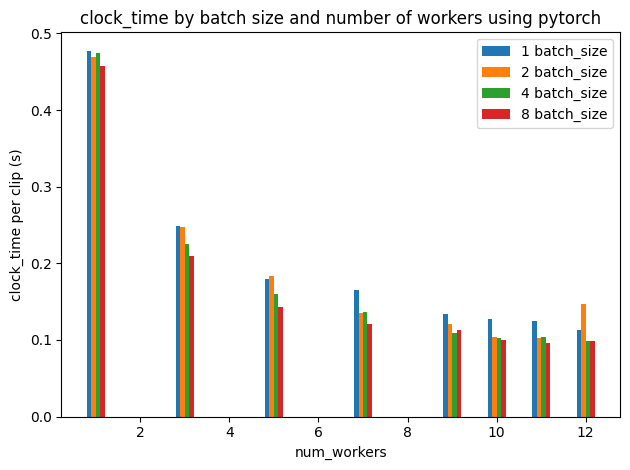

In [30]:
plot_times(data, "pytorch", "batch_size", "num_workers", "clock_time")

Observations:

- clear and diminishing decrease in clock time as batch size increases
- noticeable but more variable decrease in clock time as number of workers increases

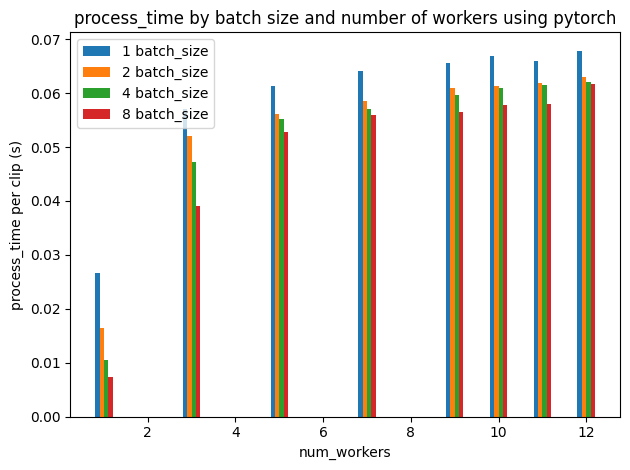

In [23]:
plot_times(data, "pytorch", "batch_size", "num_workers", "process_time")

Observations:

- Sharp initial increase in process time 
- Process time decreases with batch size

What does this mean?

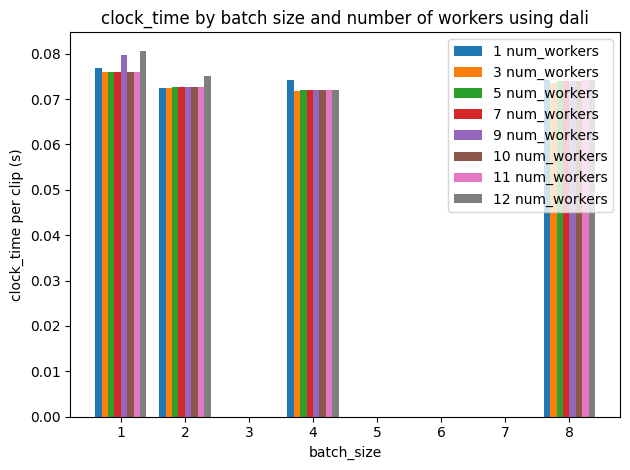

In [24]:
plot_times(data, "dali", "num_workers", "batch_size", "clock_time")

Observations:

- Batch size of 8 leads to increase in clock time; should try more batch sizes and run more trials
- Number of workers has no noticeable effect; this is expected

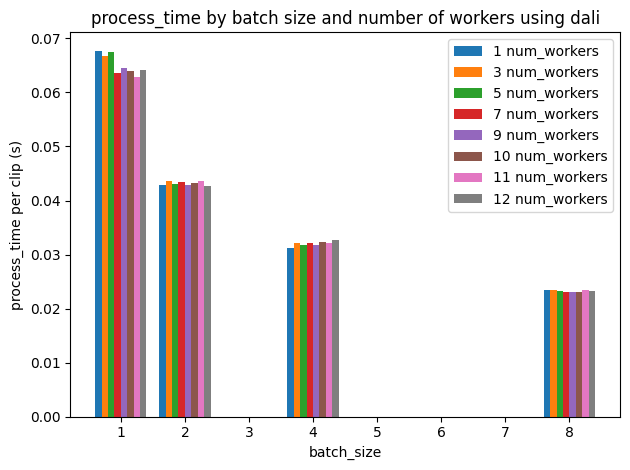

In [25]:
plot_times(data, "dali", "num_workers", "batch_size", "process_time")

Observations

- 

In [26]:
dali_data = pd.read_csv("benchmark/dali_results.csv", header=None)

In [27]:
dali_data.columns = ["dataloader", "iteration", "batch_size", "num_workers", "clock_time", "process_time", "ignore"]
dali_data.process_time = dali_data.process_time.apply(lambda x: float(x[:-1]))

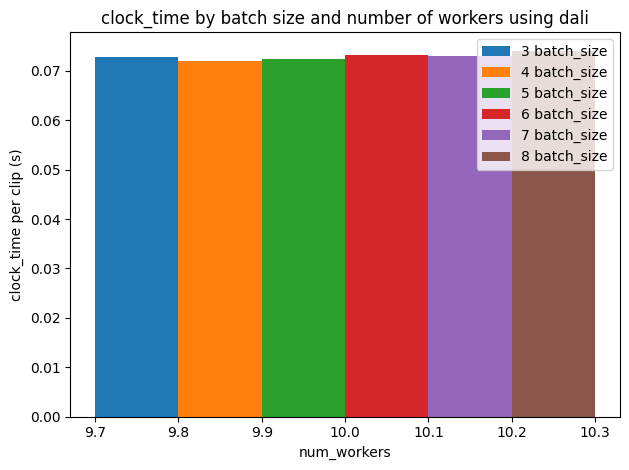

In [28]:
plot_times(dali_data, "dali", "batch_size", "num_workers", "clock_time")

Batch size has almost no impact on clock time. Process time decreases with batch size.

~70s at fastest for DALI, vs ~100s for Pytorch